# AutoGrad

AutoGrad engines are a the core of modern Deep Learning frameworks such as [PytTorch](https://pytorch.org/) and [JAX](https://jax.readthedocs.io/en/latest/#). It operates the backward gradient accumulation and computation by dynamically building an operation graph. This mechansim happens whithout the intervention of the user making the process of solving optimization problems easier for the end user. The user only needs to define the parameters to be optimized and use them to define the function that needs to be minimized or maximized with respect to those parameters.

This section of the course is an attempt at building such an engine for educational purposes. It is inspired by projects such as [PyTorch](https://pytorch.org/) from [Meta](https://about.facebook.com/en/meta/), and [MicroGrad](https://github.com/karpathy/micrograd) from [Andrej Karpathy](https://karpathy.ai/). The aim is not to develop a complete auto differetiation engine coupled with tensor computations but only to demonstrate the power of this kind of tools with a simple set of operations at the scalar level. The AutoGrad section is not mandatory to the completion of this Artificial Intelligence serie of lectures. It exists to satisfy the curiosity of those who wants to dive deeper inside the tools that we will be using throughout the next lectures.

In [328]:
from __future__ import annotations

from graphviz import Digraph
from tqdm.notebook import tqdm
from typing import Any, Callable

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random

%matplotlib inline

## Engine

For the sake of simplicty the base element of our small autograd engine will be responsible for a signle parameter. As the engine will at the end build a computation Graph for the backward pass, let us call this element a Node. The Node will carry a float for the data, its corresponding gradient, as well as its context, the operation it comes from it their is any, the child nodes of this computation, and the corresponding backward computation function for this operation.

In [329]:
class Node:
    def __init__(self, data: float, _children: set[Node] = set(), _op: str = "") -> None:
        self.data = data
        self.grad = 0.0
        self._children = _children
        self._op = _op
        self._backward = lambda: None

    def __repr__(self) -> None:
        return f"Node({self.data=}, {self.grad=})"

    __str__ = __repr__

### Operator Overloads

For ease of use and to adop a pythonic approach, we implement the majority of the operations using operator overload. It will allow the user to type operations in the following form `(2 * a + b).relu()` instead of `relu(add(mul(Node(2), a), b))`.

The operations are responsible for two things. First it computes the forward pass and convert floats to Nodes. The result of this operation is a new Node. Second, it is responsible for the computation of the backward pass for the current operation.

#### Addition

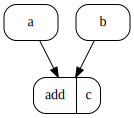

In [330]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("b", shape="record", style="rounded")
dot.node("+", "add | c", shape="record", style="rounded")
dot.edges(["a+", "b+"])
dot

The addition is a binary operation, thus has two input parameters, two contributions. Binary operations needs to compute the gradient of its two child nodes.

$$
\begin{align}
    \frac{\partial c}{\partial a} = 1 \Rightarrow \partial a = \partial c &&
    \frac{\partial c}{\partial b} = 1 \Rightarrow \partial b = \partial c
\end{align}
$$

In [331]:
def __add__(self: Node, other: float | Node) -> Node:
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data + other.data, {self, other}, _op="+")
    def _backward() -> None:
        self.grad  += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

Node.__add__ = __add__

#### Multiplication

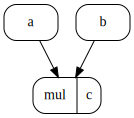

In [332]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("b", shape="record", style="rounded")
dot.node("m", "mul | c", shape="record", style="rounded")
dot.edges(["am", "bm"])
dot

$$
\begin{align}
    \frac{\partial c}{\partial a} = b \Rightarrow \partial a = b \; \partial c &&
    \frac{\partial c}{\partial b} = a \Rightarrow \partial b = a \; \partial c
\end{align}
$$

In [333]:
def __mul__(self: Node, other: float | Node) -> Node:
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data * other.data, {self, other}, _op="*")
    def _backward() -> None:
        self.grad  += other.data * out.grad
        other.grad += self.grad  * out.grad
    out._backward = _backward
    return out

Node.__mul__ = __mul__

#### Power

For simplicity, we only consider the case of a non parameter power.

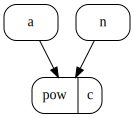

In [334]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("n", shape="record", style="rounded")
dot.node("p", "pow | c", shape="record", style="rounded")
dot.edges(["ap", "np"])
dot

$$
\begin{align}
    \frac{\partial c}{\partial a} = na^{n - 1} \Rightarrow \partial a = na^{n - 1} \; \partial c
\end{align}
$$

In [335]:
def __pow__(self: Node, other: int | float) -> Node:
    out = Node(self.data ** other, {self, }, _op=f"**{other}")
    def _backward() -> None:
        self.grad += (other * self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

Node.__pow__ = __pow__

#### More

Implementing the addition, multiplication and power operator first allow us to implement the rest of the binary operators using those as elementary building blox. 

In [336]:
def __neg__(self: Node) -> Node: return self * -1
def __sub__(self: Node, other: float | Node) -> Node: return self + -other
def __truediv__(self: Node, other: float | Node) -> Node: return self * (other ** -1)

Node.__neg__ = __neg__
Node.__sub__ = __sub__
Node.__truediv__ = __truediv__

#### Right Hand Side Operators

Python binary operators have to be implemented for bopth left and right hand side.

In [337]:
def __radd__(self: Node, other: float | Node) -> Node: return self + other
def __rsub__(self: Node, other: float | Node) -> Node: return other + -self
def __rmul__(self: Node, other: float | Node) -> Node: return self * other
def __rtruediv__(self: Node, other: float | Node) -> Node: return other * (self ** -1)

Node.__radd__ = __radd__
Node.__rsub__ = __rsub__
Node.__rmul__ = __rmul__
Node.__rtruediv__ = __rtruediv__

### Activation Functions

Binary operators are not the only set of operations that are required for Deep Learning. In this subsection, we implement a small set of mathemical functions such as the exponential and the logarithm as well as some iconic activation functions such as ReLU, Sigmoid, and TanH.

#### Exponential

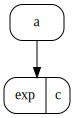

In [338]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("e", "exp | c", shape="record", style="rounded")
dot.edges(["ae"])
dot

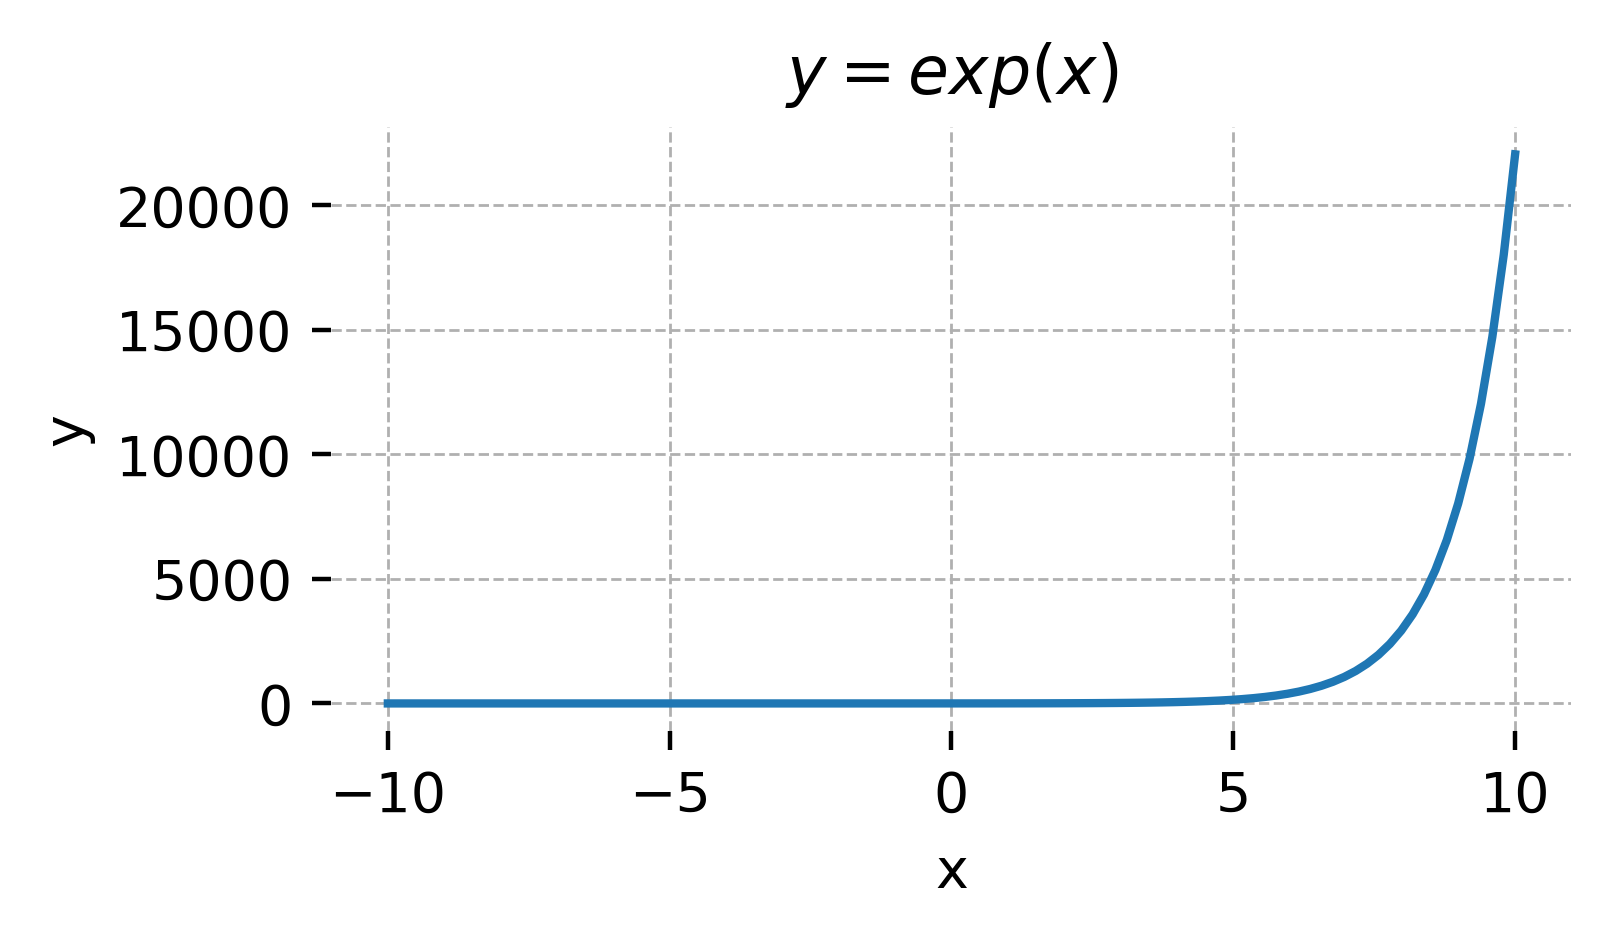

In [339]:
x = np.linspace(-10, 10, 100)
y = np.exp(x)

fig = plt.figure(figsize=(4, 2), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("$y = exp(x)$")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()

$$
\begin{align}
    c = exp(a) &&
    \frac{\partial c}{\partial a} = c \Rightarrow \partial a = c \; \partial c
\end{align}
$$

In [340]:
def exp(self: Node) -> Node:
    out = Node(np.exp(self.data), {self, }, _op="exp")
    def _backward() -> None:
        self.grad += out.data * out.grad
    out._backward = _backward
    return out

Node.exp = exp

#### Logarithm

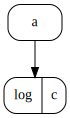

In [341]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("l", "log | c", shape="record", style="rounded")
dot.edges(["al"])
dot

/tmp/ipykernel_123719/2424356897.py:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)


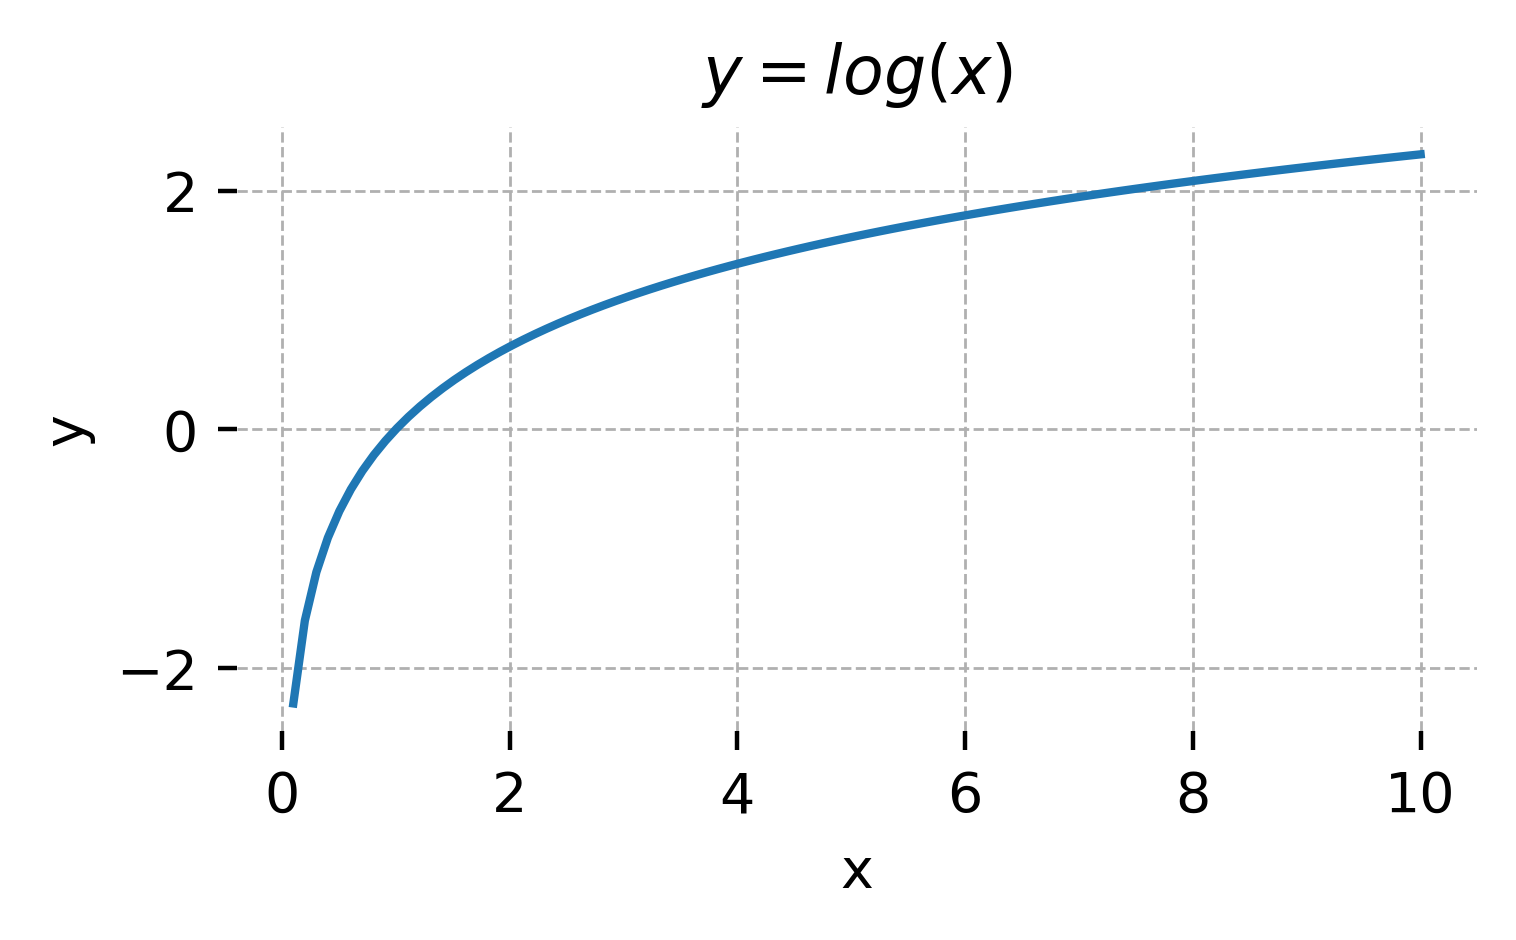

In [342]:
x = np.linspace(0, 10, 100)
y = np.log(x)

fig = plt.figure(figsize=(4, 2), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("$y = log(x)$")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()

$$
\begin{align}
    c = log(a) &&
    \frac{\partial c}{\partial a} = \frac{1}{a} \Rightarrow \partial a = a \; \partial c
\end{align}
$$

In [343]:
def log(self: Node) -> Node:
    out = Node(np.log(self.data), {self, }, _op="log")
    def _backward() -> None:
        self.grad += self.data * out.grad
    out._backward = _backward
    return out

Node.log = log

#### Recitfied Linear Unit

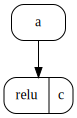

In [344]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("r", "relu | c", shape="record", style="rounded")
dot.edges(["ar"])
dot

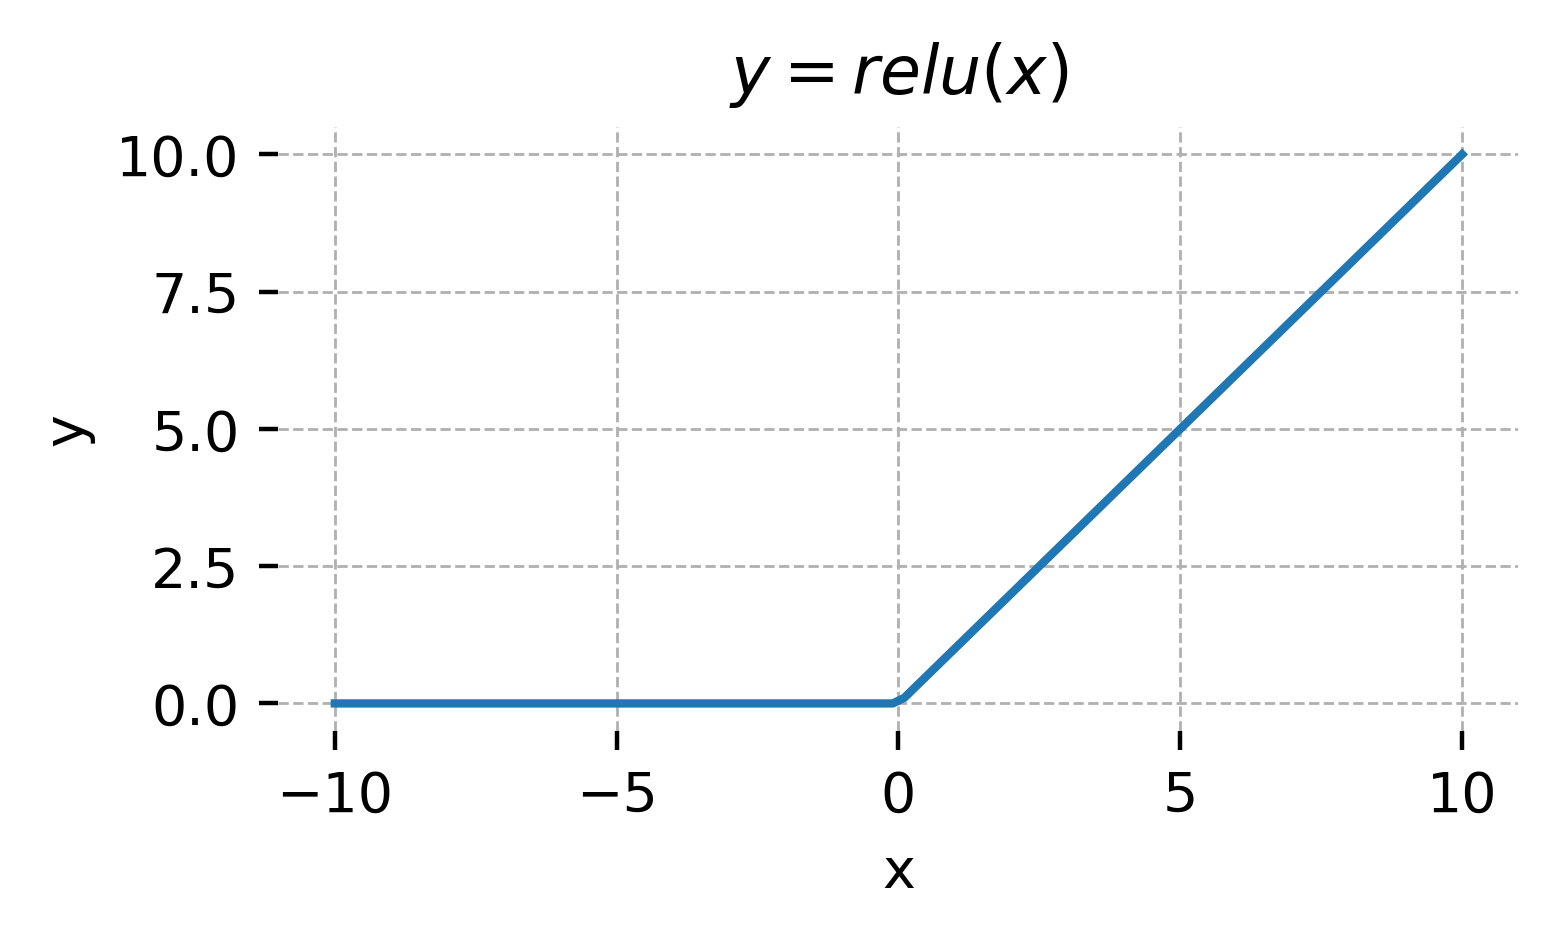

In [345]:
x = np.linspace(-10, 10, 100)
y = (x > 0)* x

fig = plt.figure(figsize=(4, 2), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("$y = relu(x)$")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()

$$
\begin{align}
    c = max(0, a) &&
    \frac{\partial c}{\partial a} = \begin{cases}
        a & \text{ if } a > 0 \\ 
        0 & \text{ else } 
    \end{cases}
    \Rightarrow
    \partial a = \begin{cases}
        \partial{c} & \text{ if } a > 0 \\ 
        0 & \text{ else } 
    \end{cases}
\end{align}
$$

In [346]:
def relu(self: Node) -> Node:
    out = Node(max(0, self.data), {self, }, _op="relu")
    def _backward() -> None:
        self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out

Node.relu = relu

#### Hyperbolic Tangent

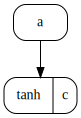

In [347]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("t", "tanh | c", shape="record", style="rounded")
dot.edges(["at"])
dot

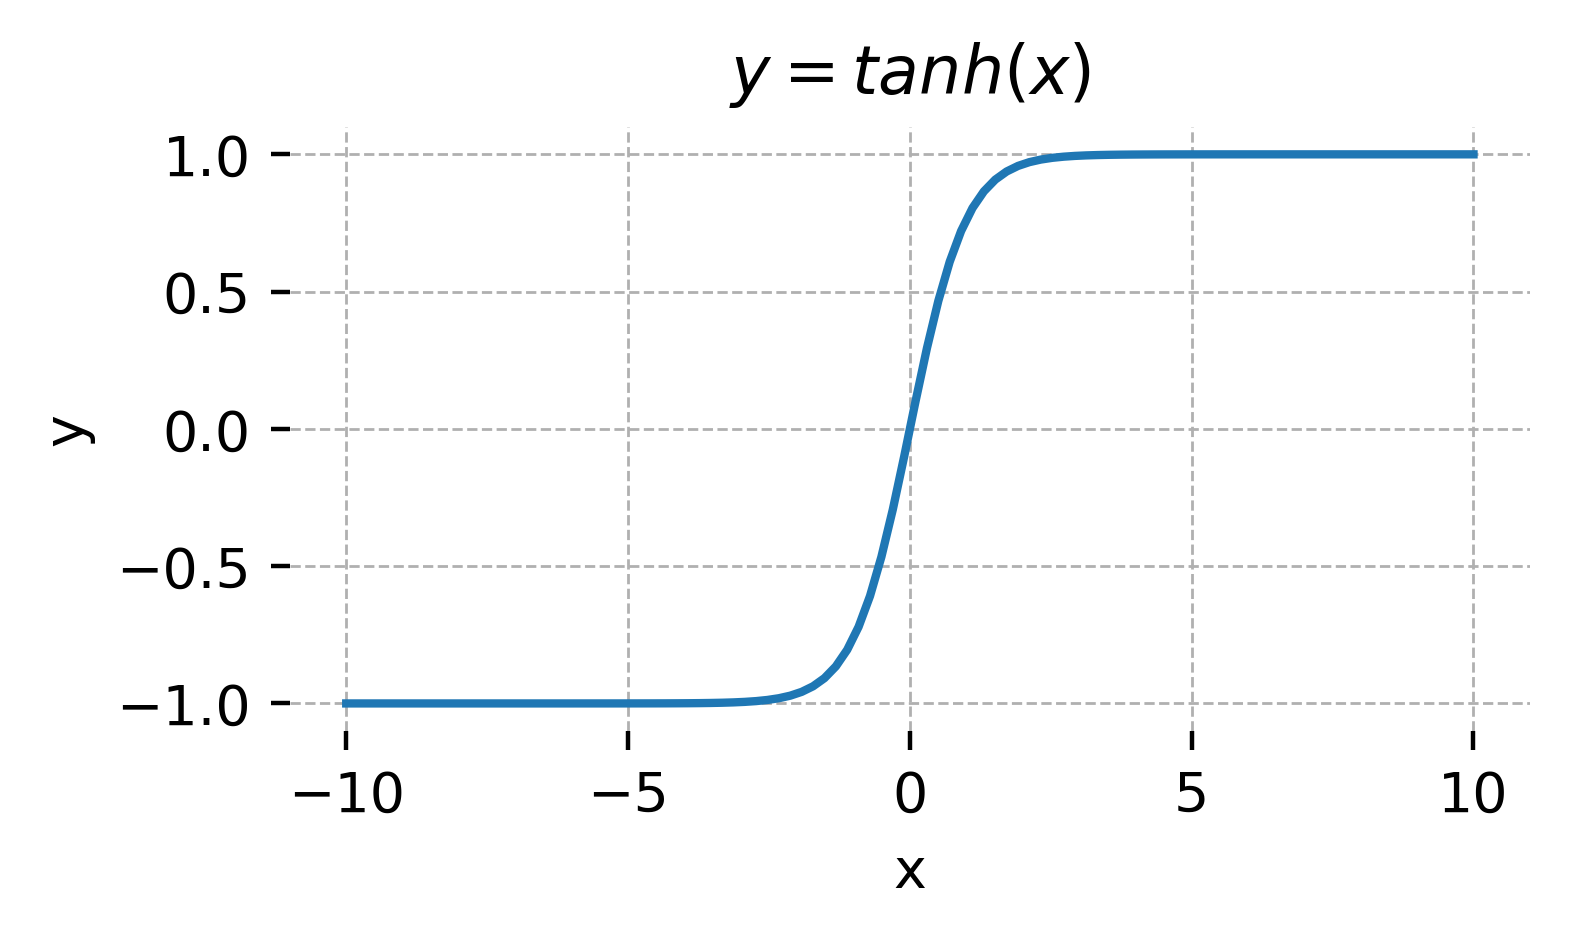

In [348]:
x = np.linspace(-10, 10, 100)
y = np.tanh(x)

fig = plt.figure(figsize=(4, 2), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("$y = tanh(x)$")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()

$$
\begin{align}
    c = tanh(a) &&
    \frac{\partial c}{\partial a} = \frac{1}{1 - a^2} \Rightarrow \partial a = (1 - a^2) \; \partial c
\end{align}
$$

In [349]:
def tanh(self: Node) -> Node:
    out = Node((np.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), {self, }, _op="tanh")
    def _backward() -> None:
        self.grad += (1 - self.data ** 2) * out.grad
    out._backward = _backward
    return out

Node.tanh = tanh

#### Sigmoid / Logistic

The sigmoid function can be expressed a scaled and translated version of the hyperbolic tangent:

$$
\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{1}{2} (tanh(\frac{1}{2} \; x) + 1)
$$

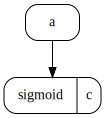

In [350]:
dot = Digraph()
dot.node("a", shape="record", style="rounded")
dot.node("s", "sigmoid | c", shape="record", style="rounded")
dot.edges(["as"])
dot

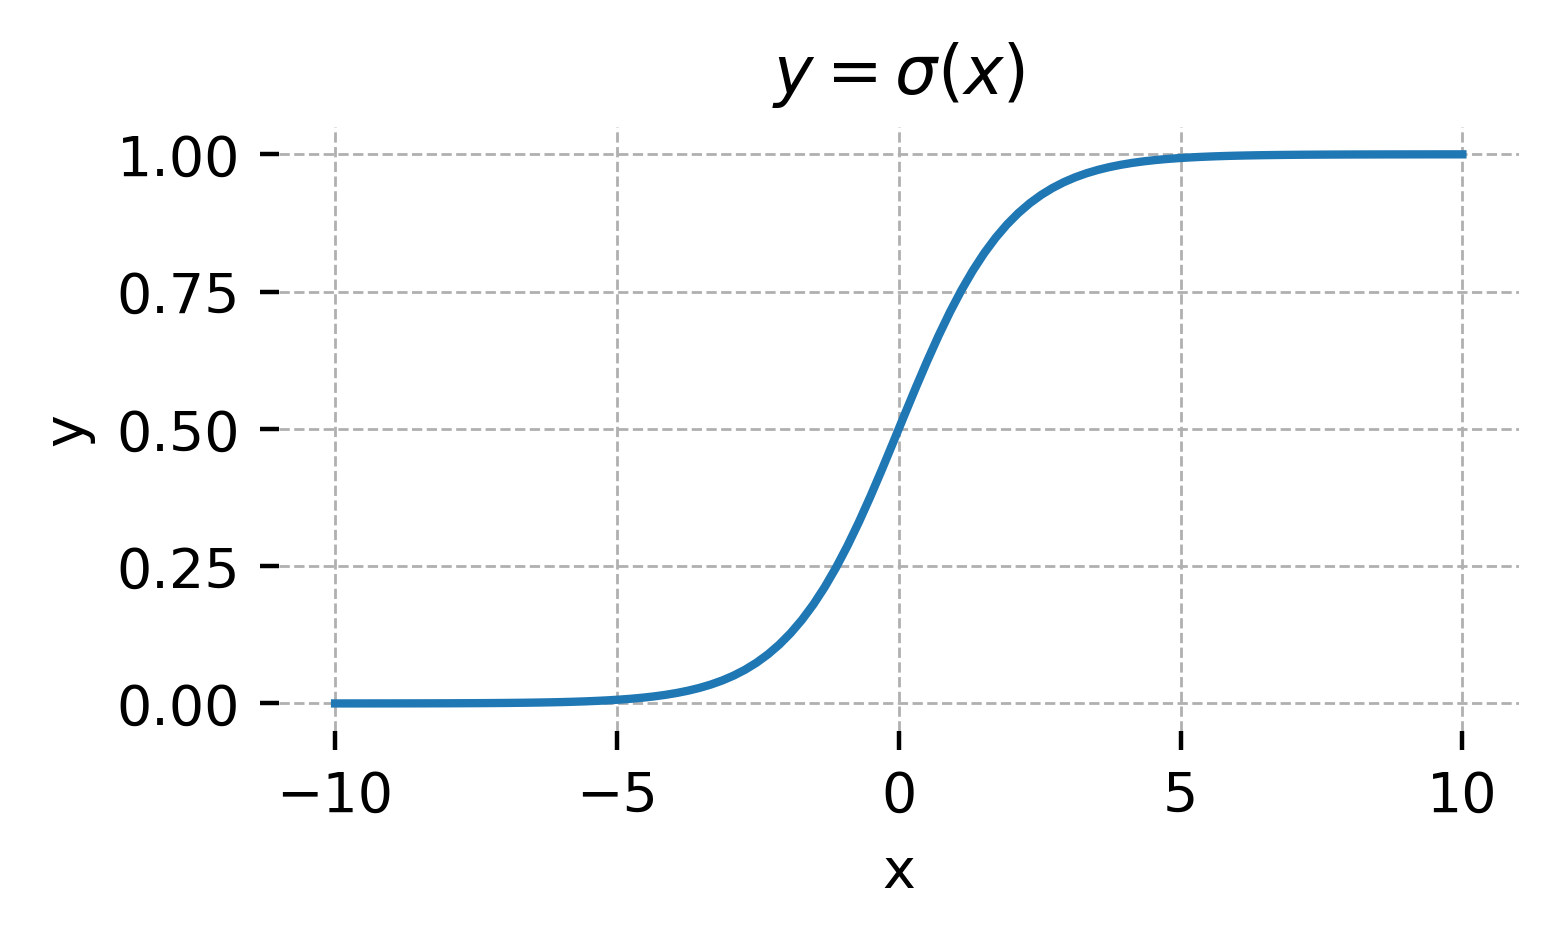

In [351]:
x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))

fig = plt.figure(figsize=(4, 2), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("$y =  \sigma(x)$")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()

In [352]:
def sigmoid(self: Node) -> Node:
    return 0.5 * ((0.5 * self).tanh() + 1)

Node.sigmoid = sigmoid

### Backward Pass

The bakcward pass is reponsible for building the Directed Acyclic Graph (DAG) of the computation in backward order. This operation is often referrred to as tracing. It then traverse this graph from end to begining while computer the graph of each node, element, using the chain rule.

$$
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \; \frac{\partial y}{\partial x}
$$

In [353]:
def backward(self: Node) -> None:
    graph, visited = [], set()
    def trace_graph(node: Node) -> None:
        if node not in visited:
            visited.add(node)
            for child in node._children:
                trace_graph(child)
            graph.append(node)
    trace_graph(self)

    self.grad = 1.0
    for node in reversed(graph):
        node._backward()

Node.backward = backward

## Module

Neural Networks are composed of layers of parametrized neurons. In modern Deep Learning frameworks, the different layer architectures are considered like lego blocks, modules, that can be plug together to form the final network. The Module class serves this purpose as well as providing a set of helper functions such as listing the parameters of the module, resetting their values, reset their gradient to zero, and the forward pass. Some of these methods / functions will need to be overwritten when extended. 

In [354]:
class Module:
    def parameters(self) -> list[Node]:
        return []

    def reset(self) -> None:
        ...
    
    def zero_grad(self) -> None:
        for param in self.parameters():
            param.grad = 0.0

    def forward(self, *args, **kwargs) -> Node | list[Node]:
        raise NotImplementedError

    def __call__(self, *args, **kwargs) -> Node | list[Node]:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str: return "Module()"

    __str__ = __repr__

### Weight Initialization

The initialization of neural nets parameters is important as it determines the initial loss landscape and will affect the gradient descent. A set of good initializations have been determined over the year in the litterature. Here we implement some of them and will use them depending on the activation functon used by the module.

#### Zero Initialization

$\theta = 0$

In [355]:
def init_zero(self: Node) -> None:
    self.data = 0.0

Node.init_zero = init_zero

#### Uniform Initialization

$\theta \sim \mathcal{U}(-1, 1)$

In [356]:
def init_uniform(self: Node, a: float = -1.0, b: float = 1.0) -> None:
    self.data = random.uniform(-1.0, 1.0)

Node.init_uniform = init_uniform

#### Xavier Initialization

$\theta \sim \mathcal{U}(-\frac{1}{n_{in}}, \frac{1}{n_{in}})$

In [357]:
def init_xavier(self: Node, n_in: int) -> None:
    self.data = random.uniform(-1.0, 1.0) / np.sqrt(n_in)

Node.init_xavier = init_xavier

#### Gaussian Initialization

$\theta \sim \mathcal{N}(0, \frac{1}{n_{in}})$

In [358]:
def init_gaussian(self: Node, n_in: int) -> None:
    self.data = random.normal(0, np.sqrt(1.0 / n_in))

Node.init_gaussian = init_gaussian

### Perceptron

The Perceptron is one of the oldest basic block of neural nets. It tries to replicated a simple model of the biological neurons of our brain. It can be resume to an activated weighted sum of inputs from previous neurons.

In [359]:
Activation = Callable[[Node], Node]
class Perceptron(Module):
    def __init__(self, n_in: int, activation: Activation = sigmoid) -> None:
        super().__init__()
        self.n_in = n_in
        self.activation = activation
        self.w = [Node(0.0) for _ in range(n_in)]
        self.b = Node(0.0)
        self.reset()

    def __repr__(self) -> str:
        return f"Perceptron({self.n_in=}, {self.activation=})"

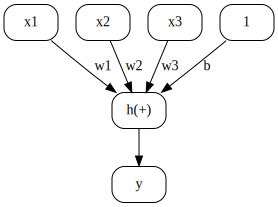

In [360]:
dot = Digraph()
dot.node("x1", shape="record", style="rounded")
dot.node("x2", shape="record", style="rounded")
dot.node("x3", shape="record", style="rounded")
dot.node("1", shape="record", style="rounded")
dot.node("h(+)", shape="record", style="rounded")
dot.node("y", shape="record", style="rounded")
dot.edge("x1", "h(+)", "w1")
dot.edge("x2", "h(+)", "w2")
dot.edge("x3", "h(+)", "w3")
dot.edge("1", "h(+)", "b")
dot.edge("h(+)", "y")
dot

In [361]:
def forward(self: Perceptron, x: list[Node]) -> Node:
    return self.activation(sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b))

Perceptron.forward = forward

In [362]:
def parameters(self: Perceptron) -> list[Node]:
    return self.w + [self.b]

Perceptron.parameters = parameters

In [363]:
def reset(self: Perceptron) -> None:
    self.b.init_zero()
    for w_i in self.w:
        if self.activation == tanh or self.activation == sigmoid: w_i.init_xavier(self.n_in)
        elif self.activation == relu: w_i.init_gaussian(self.n_in)
        else: w_i.init_uniform()

Perceptron.reset = reset

### Layer

A layer is a collection of Perceptrons. Its output has a size equal to the number of neurons in the layer.

In [364]:
class Linear(Module):
    def __init__(self, n_in: int, n_out: int, activation: Activation = relu) -> None:
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.activation = activation
        self.neurons = [Perceptron(n_in, activation) for _ in range(n_out)]

    def reset(self) -> None:
        for neuron in self.neurons:
            neuron.reset()

    def __repr__(self) -> str:
        return f"Linear({self.n_in=}, {self.n_out=}, {self.activation=})"

    def forward(self, x: list[Node]) -> Node | list[Node]:
        if self.n_out == 1: return self.neurons[0](x)
        return [neuron(x) for neuron in self.neurons]

    def parameters(self) -> list[Node]:
        return [param for neuron in self.neurons for param in neuron.parameters()]

### Sequential

The Sequential module is a helper module that plugs a given ordered collection of modules in a sequential manner. It allows the user to specify a sequence of modules without the need for implementing its forward pass for convenience.

In [365]:
class Sequential(Module):
    def __init__(self, *modules: tuple[Module]) -> None:
        super().__init__()
        self.modules = modules

    def reset(self) -> None:
        for module in self.modules:
            module.reset()

    def __repr__(self) -> str:
        return f"Sequential({self.modules=})"

    def forward(self, x: list[Node]) -> Node | list[Node]:
        for module in self.modules:
            x = module(x)
        return x

    def parameters(self) -> list[Node]:
        return [param for module in self.modules for param in module.parameters()]

### Multi Layer Perceptron

The Multi Layer Perceptron (MLP) is a sequence of activated Layers. If we forget to activate the layers (i.e. activation is set to indentity), the entire network can be collapsed into one and unique single Linear module.

In [366]:
class MLP(Sequential):
    def __init__(self, *sizes: tuple[int], activation: Activation = relu) -> None:
        super().__init__(*(
            Linear(n_in, n_out, sigmoid if i == len(sizes) - 1 else activation)
            for i, (n_in, n_out) in enumerate(zip(sizes[:-1], sizes[1:]))
        ))

## Losses

Losses, or Objective Functions, are reponsible for mesuring the distance from prediction to ground-truth data. It representes the error of estimation and is the value we want to minimize with respect to the network parameters in order to train our model. In frameworks such as PyTorch, those functions are often implemented as modules. Here for the sake of simplicity, they are functions. 

### Squared Error

The Squared Error (SE) is the euclidean distance. It is the squared difference of two quantities.

$(\hat{y} - y)^{2}$

In [367]:
def squared_error(y_: Node, y: int) -> Node:
    return (y_ - y) ** 2

### Binary Cross Entropy

The Binary Cross Entropy (BCE) is the Cross Entropy of a binary variable defined in the Information Theory developped by Claude Shannon. Its value is low when the two input quantities match, but high when they diverge.

$y \; log(\hat{y}) + (1 - y) \; log(1 - \hat{y})$

In [368]:
def binary_cross_entropy(y_: Node, y: int) -> Node:
    return -(y * y_.log() + (1.0 - y) * (1.0 - y_).log())

## Optimizer

The optimizer is the entity responsible for the update of the module parameters, the neural network weights. It is the one that will perform the gradient descent step for training. Different version have been proposed in the literature. Some incorporate notions of momentum and tricks to make the gradient descent faster, more stable, avoid beign stuck in an avoidable local minima, and more.

In [369]:
class Optimizer:
    def __init__(self, parameters: list[Node], lr: float) -> None:
        self.parameters = parameters
        self.lr = lr

    def step(self) -> None:
        raise NotImplementedError

    def zero_grad(self) -> None:
        for param in self.parameters:
            param.grad = 0.0

    def __repr__(self) -> str:
        return f"Optimizer({self.lr})"

    __str__ = __repr__

### Stochastic Gradient Descent

The Stochastic Gradient Descent optimizer is the easiest to implement. In our case, we should not use the world stochastic as we will train our model on the entire dataset in one step. The name is kept to match with the PyTorch API.

In [370]:
class SGD(Optimizer):
    def __init__(self, parameters: list[Node], lr: float) -> None:
        super().__init__(parameters, lr)

    def __repr__(self) -> str:
        return f"SGD({self.lr=})"

The update rule is the following:

$$
w \leftarrow w - \alpha \; \frac{\partial \mathcal{L(\hat{y}, y)}}{\partial w}
$$

In [371]:
def step(self: SGD) -> None:
    for i, param in enumerate(self.parameters):
        param.data -= self.lr * param.grad

SGD.step = step

### Stochastic Gradient Descent with Momentum

Momentum SGD is an augmented version of the SGD with momentum. It allows the gradient to take in consideration the speed at which the loss landscape is traversed and avoid (in some cases) being stuck in small crevasses or saddle points.

In [372]:
class MomentumSGD(Optimizer):
    def __init__(self, parameters: list[Node], lr: float, momentum: float = 0.0) -> None:
        super().__init__(parameters, lr)
        self.momentum = momentum
        self.states = [0.0 for param in parameters]

    def __repr__(self) -> str:
        return f"MomentumSGD({self.lr=}, {self.momentum=})"

The update rule is the following:

$$
w \leftarrow w - \alpha \; (\frac{\partial \mathcal{L(\hat{y}, y)}}{\partial w})_t + \gamma \; (\alpha \; (\frac{\partial \mathcal{L(\hat{y}, y)}}{\partial w})_{t - 1})
$$

In [373]:
def step(self: MomentumSGD) -> None:
    for i, param in enumerate(self.parameters):
        direction = self.lr * param.grad
        param.data -= direction + self.momentum * self.states[i]
        self.states[i] = self.lr * param.grad

MomentumSGD.step = step

## Dataset

A Dataset is a collection of data that is used to build a parametrized model in response to a problem. In the case of a supervised learning approach, it consists of a collection of features and label pairs. The features are the data descriptors used as input to the model, and the label corresponds to the index of the class corresponding to those descriptors (e.g. a "cat" as $0$, a "dog" as $1$).

The Dataset class provides a simple interface for working with such a kind of data structure. It allows to get the dataset length, a sample given its index, and to shuffle the dataset (useful for the stochastic part of the SGD).

In [374]:
class Dataset:
    def __len__(self) -> int: return 0
    def __getitem__(self, idx: int) -> Any: return None
    def shuffle(self) -> None: ...

### Toy Dataset for Binary Classification

Here we implement a simple binary classification dataset base class. A plot method is also added to the class for visualization pruposes.

In [375]:
class ToyDataset(Dataset):
    def __init__(self, X: list[list[float]], Y: list[int]) -> None:
        super().__init__()
        self.X = X
        self.Y = Y

    def __len__(self) -> int: return len(self.Y)
    def __getitem__(self, idx: int) -> tuple[list[float], int]: return self.X[idx], self.Y[idx]
    
    def shuffle(self) -> None:
        idxs = list(range(len(self)))
        random.shuffle(idxs)
        self.X = [self.X[idx] for idx in idxs]
        self.Y = [self.Y[idx] for idx in idxs]

    def plot(self) -> None:
        fig = plt.figure(figsize=(4, 4), dpi=400)
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(
            x=[x_1 for x_1, _ in self.X],
            y=[x_2 for _, x_2 in self.X],
            c=["r" if label == 0 else "b" for label in self.Y],
        )
        ax.set_title("Dataset")
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        ax.grid(linestyle="--", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        fig.canvas.draw()
        plt.show()

### Linear Dataset

A simple Linearly separable two classes dataset.

In [376]:
class LinearDataset(ToyDataset):
    def __init__(self) -> None:
        super().__init__(
            X=[
                [-1.0,  1.0],
                [-0.5,  0.5],
                [-0.5,  1.0],
                [ 1.0, -1.0],
                [ 0.5, -0.5],
                [ 1.0, -0.5],
            ],
            Y=[0, 0, 0, 1, 1, 1],
        )

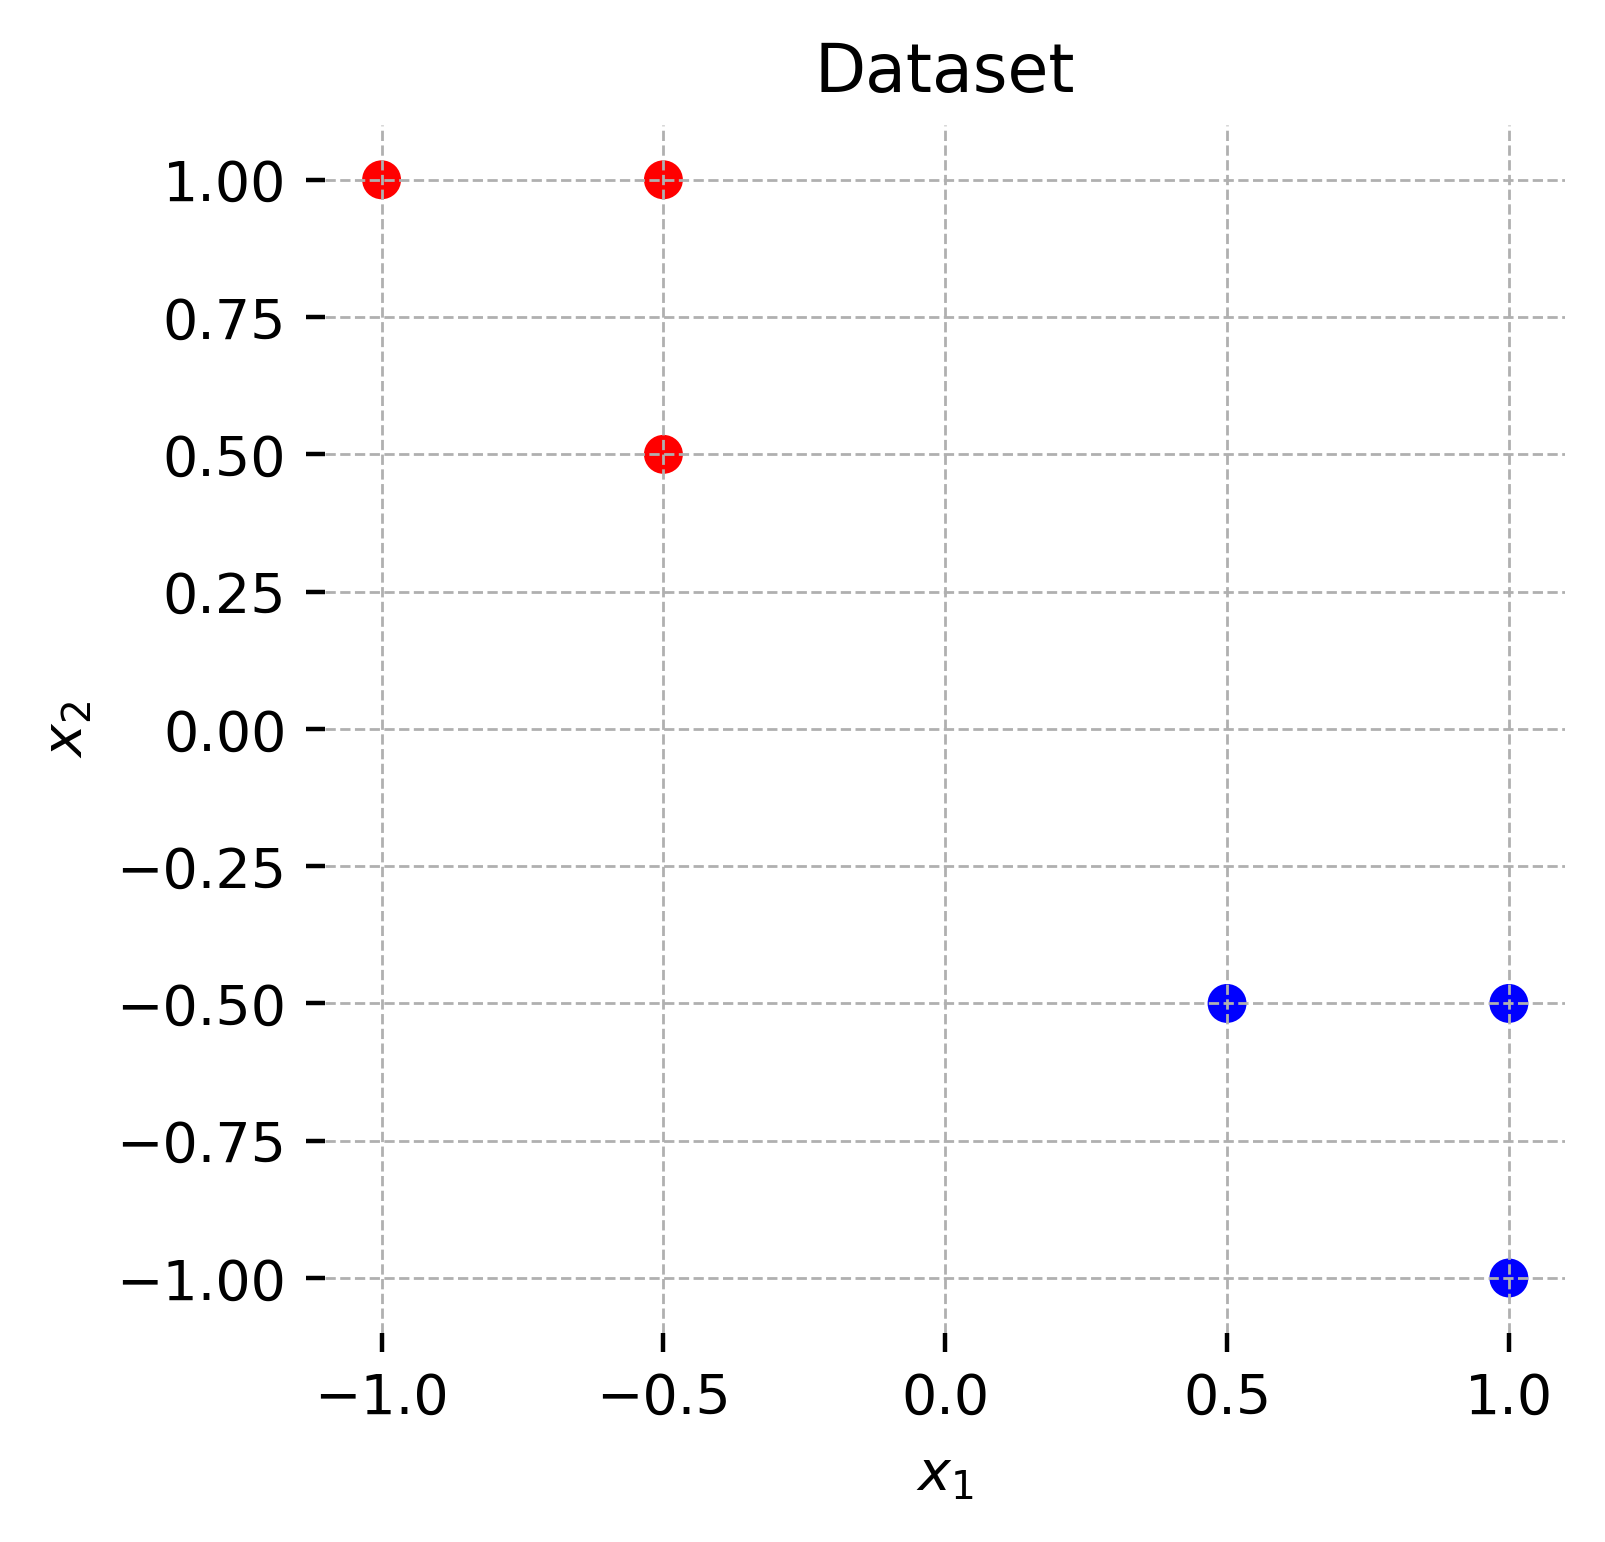

In [377]:
linear_dataset = LinearDataset()
linear_dataset.plot()

### Non Linear Dataset

A simple non Linearly separable two classes dataset.

In [378]:
class NonLinearDataset(ToyDataset):
    def __init__(self) -> None:
        super().__init__(
            X=[
                [-1.0,  1.0],
                [-1.0,  0.5],
                [-0.5,  1.0],
                [-0.5,  0.5],
                [ 0.5, -0.5],
                [ 0.5, -1.0],
                [ 1.0, -0.5],
                [ 1.0, -1.0],
                
                [-1.0, -0.5],
                [-1.0, -1.0],
                [-0.5, -0.5],
                [-0.5, -1.0],
                [ 0.5,  0.5],
                [ 0.5,  1.0],
                [ 1.0,  0.5],
                [ 1.0,  1.0],
            ],
            Y=[
                0, 0, 0, 0, 0, 0, 0, 0,
                1, 1, 1, 1, 1, 1, 1, 1,
            ],
        )

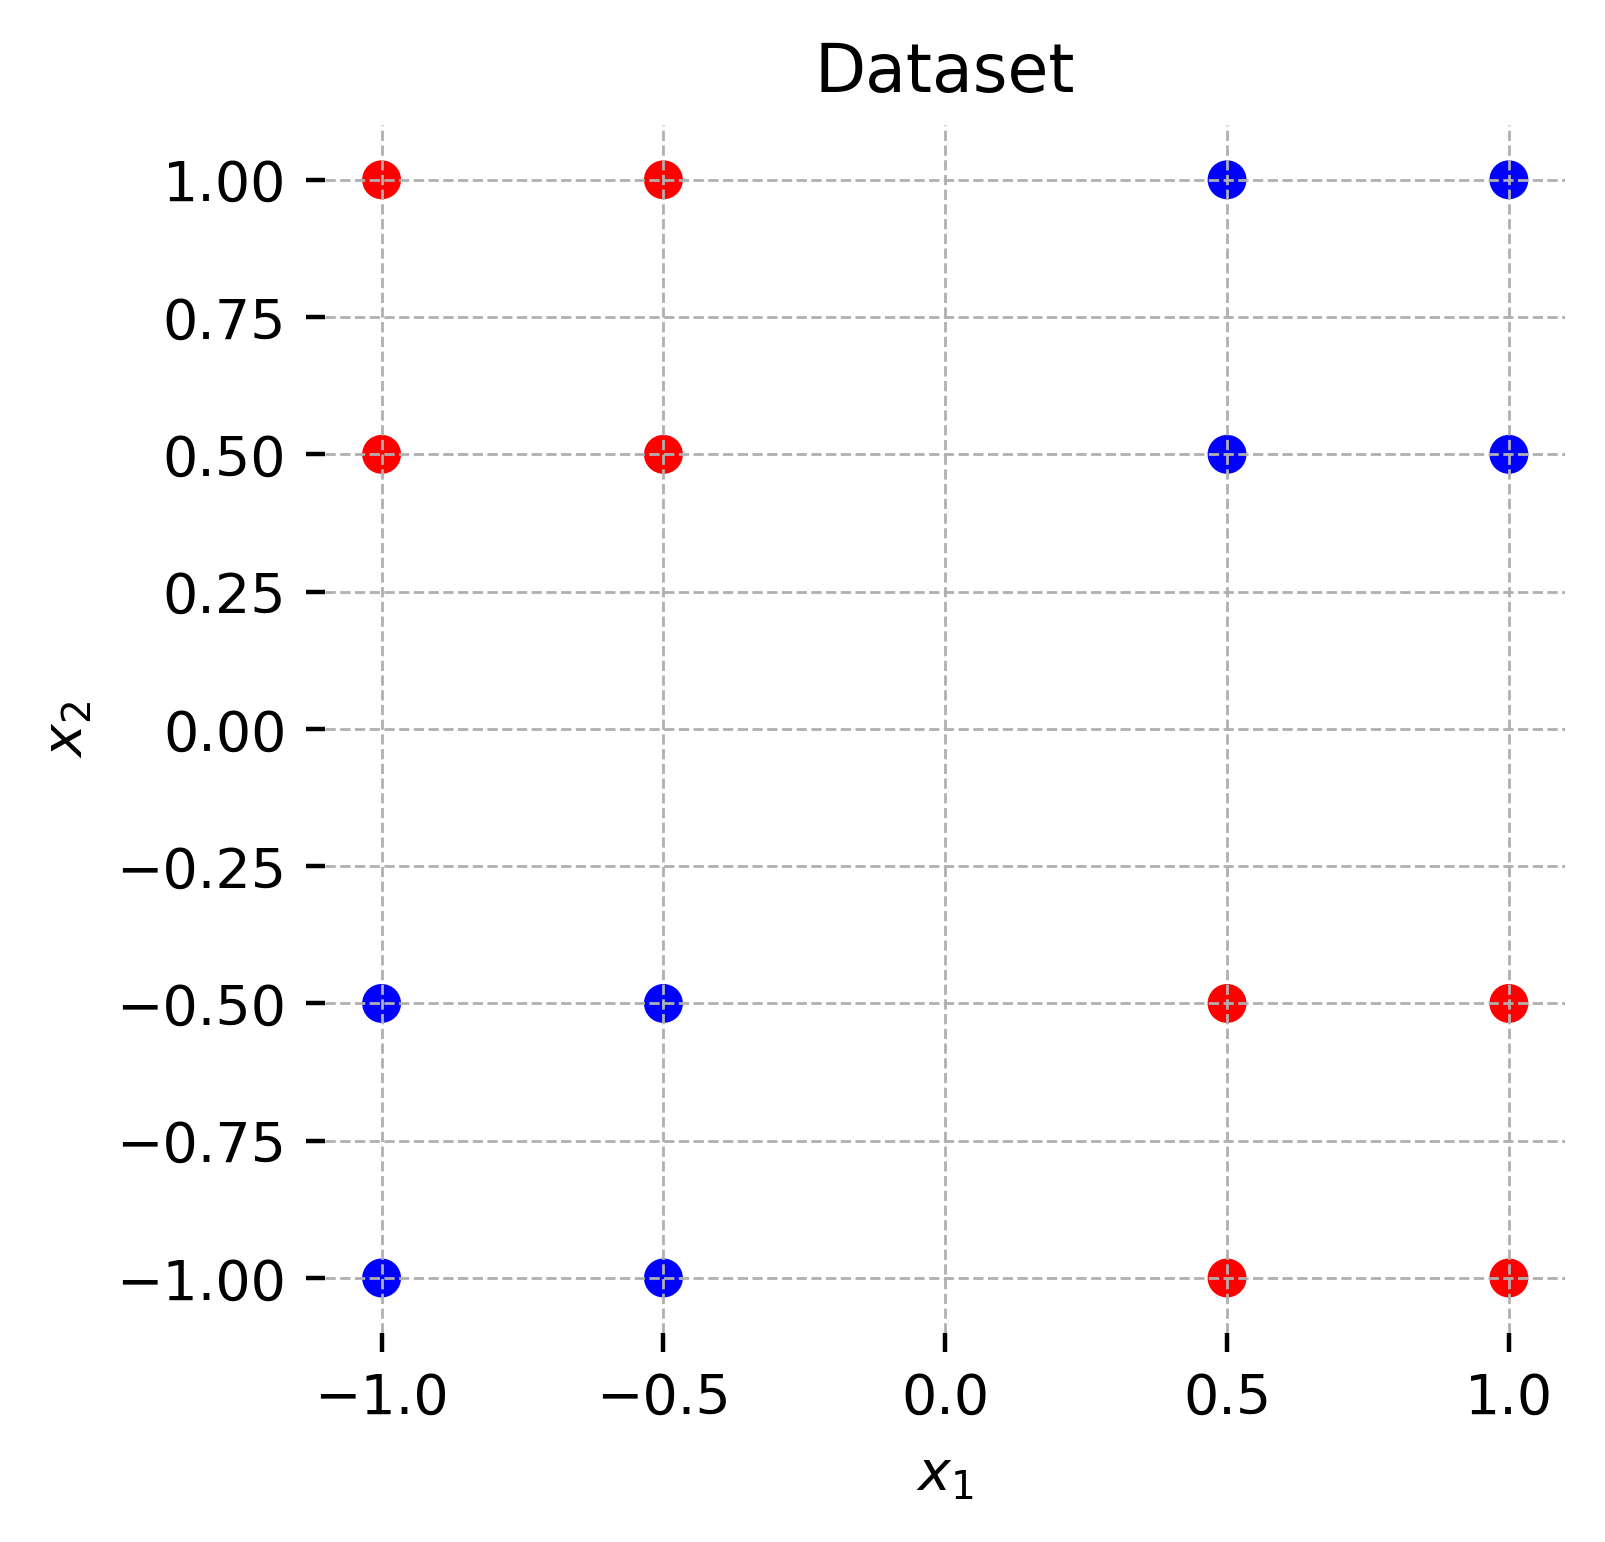

In [379]:
nonlinear_dataset = NonLinearDataset()
nonlinear_dataset.plot()

## Training

Training is what we call the process of optimizing the model's parameters with respect to the objective function. It consists in computing the model's prediction given inputs, evaluating the error given ground-truth, and performing gradient descent using backpropagation.

### History

The history class is a helper for monitoring the training progress using the error metric, and in our case, for classification, the accuracy. In real world scenario, one have to split the dataset into different splits, the train split, valid split, and test split. Here for the sake of simplicity we only use a single split, the train. Monitoring the metrics for train only does not provide a good insight on model generalisation, the capcity of performing well on unseen data.

In [380]:
class History:
    def __init__(self) -> None:
        self.loss = []
        self.acc = []

    def __len__(self) -> int:
        assert len(self.loss) == len(self.acc)
        return len(self.loss)

    def plot(self) -> None:
        fig = plt.figure(figsize=(2 * 4, 4), dpi=400)
        ax = fig.add_subplot(2, 1, 1)
        ax.plot(list(range(len(self))), self.loss, color="r")
        ax.set_title("Loss History")
        ax.set_xlabel("epoch")
        ax.set_ylabel("loss")
        ax.grid(linestyle="--", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax = fig.add_subplot(2, 1, 2)
        ax.plot(list(range(len(self))), self.acc, color="b")
        ax.set_title("Accuracy History")
        ax.set_xlabel("epoch")
        ax.set_ylabel("accuracy in %")
        ax.set_ylim(0.0, 100.0)
        ax.grid(linestyle="--", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        fig.canvas.draw()
        fig.tight_layout()
        plt.show()

### Linear Problem

In this section we train a simple Perceptron to solve a simple linear separable problem, a binary classifcation task.

#### Hyperparameters

The hyperparameters is the name of the collection of parameters that will influence the training of the network, the learning rate, the number of epochs, the batch size, the optimizer parameters, and more.

In [402]:
epochs = 2_000
lr = 1e-3
momentum = 0.9

#### Model and Optimizer

In [403]:
model = Perceptron(2, activation=sigmoid)
optim = MomentumSGD(model.parameters(), lr=lr, momentum=momentum)

#### Training Loop

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

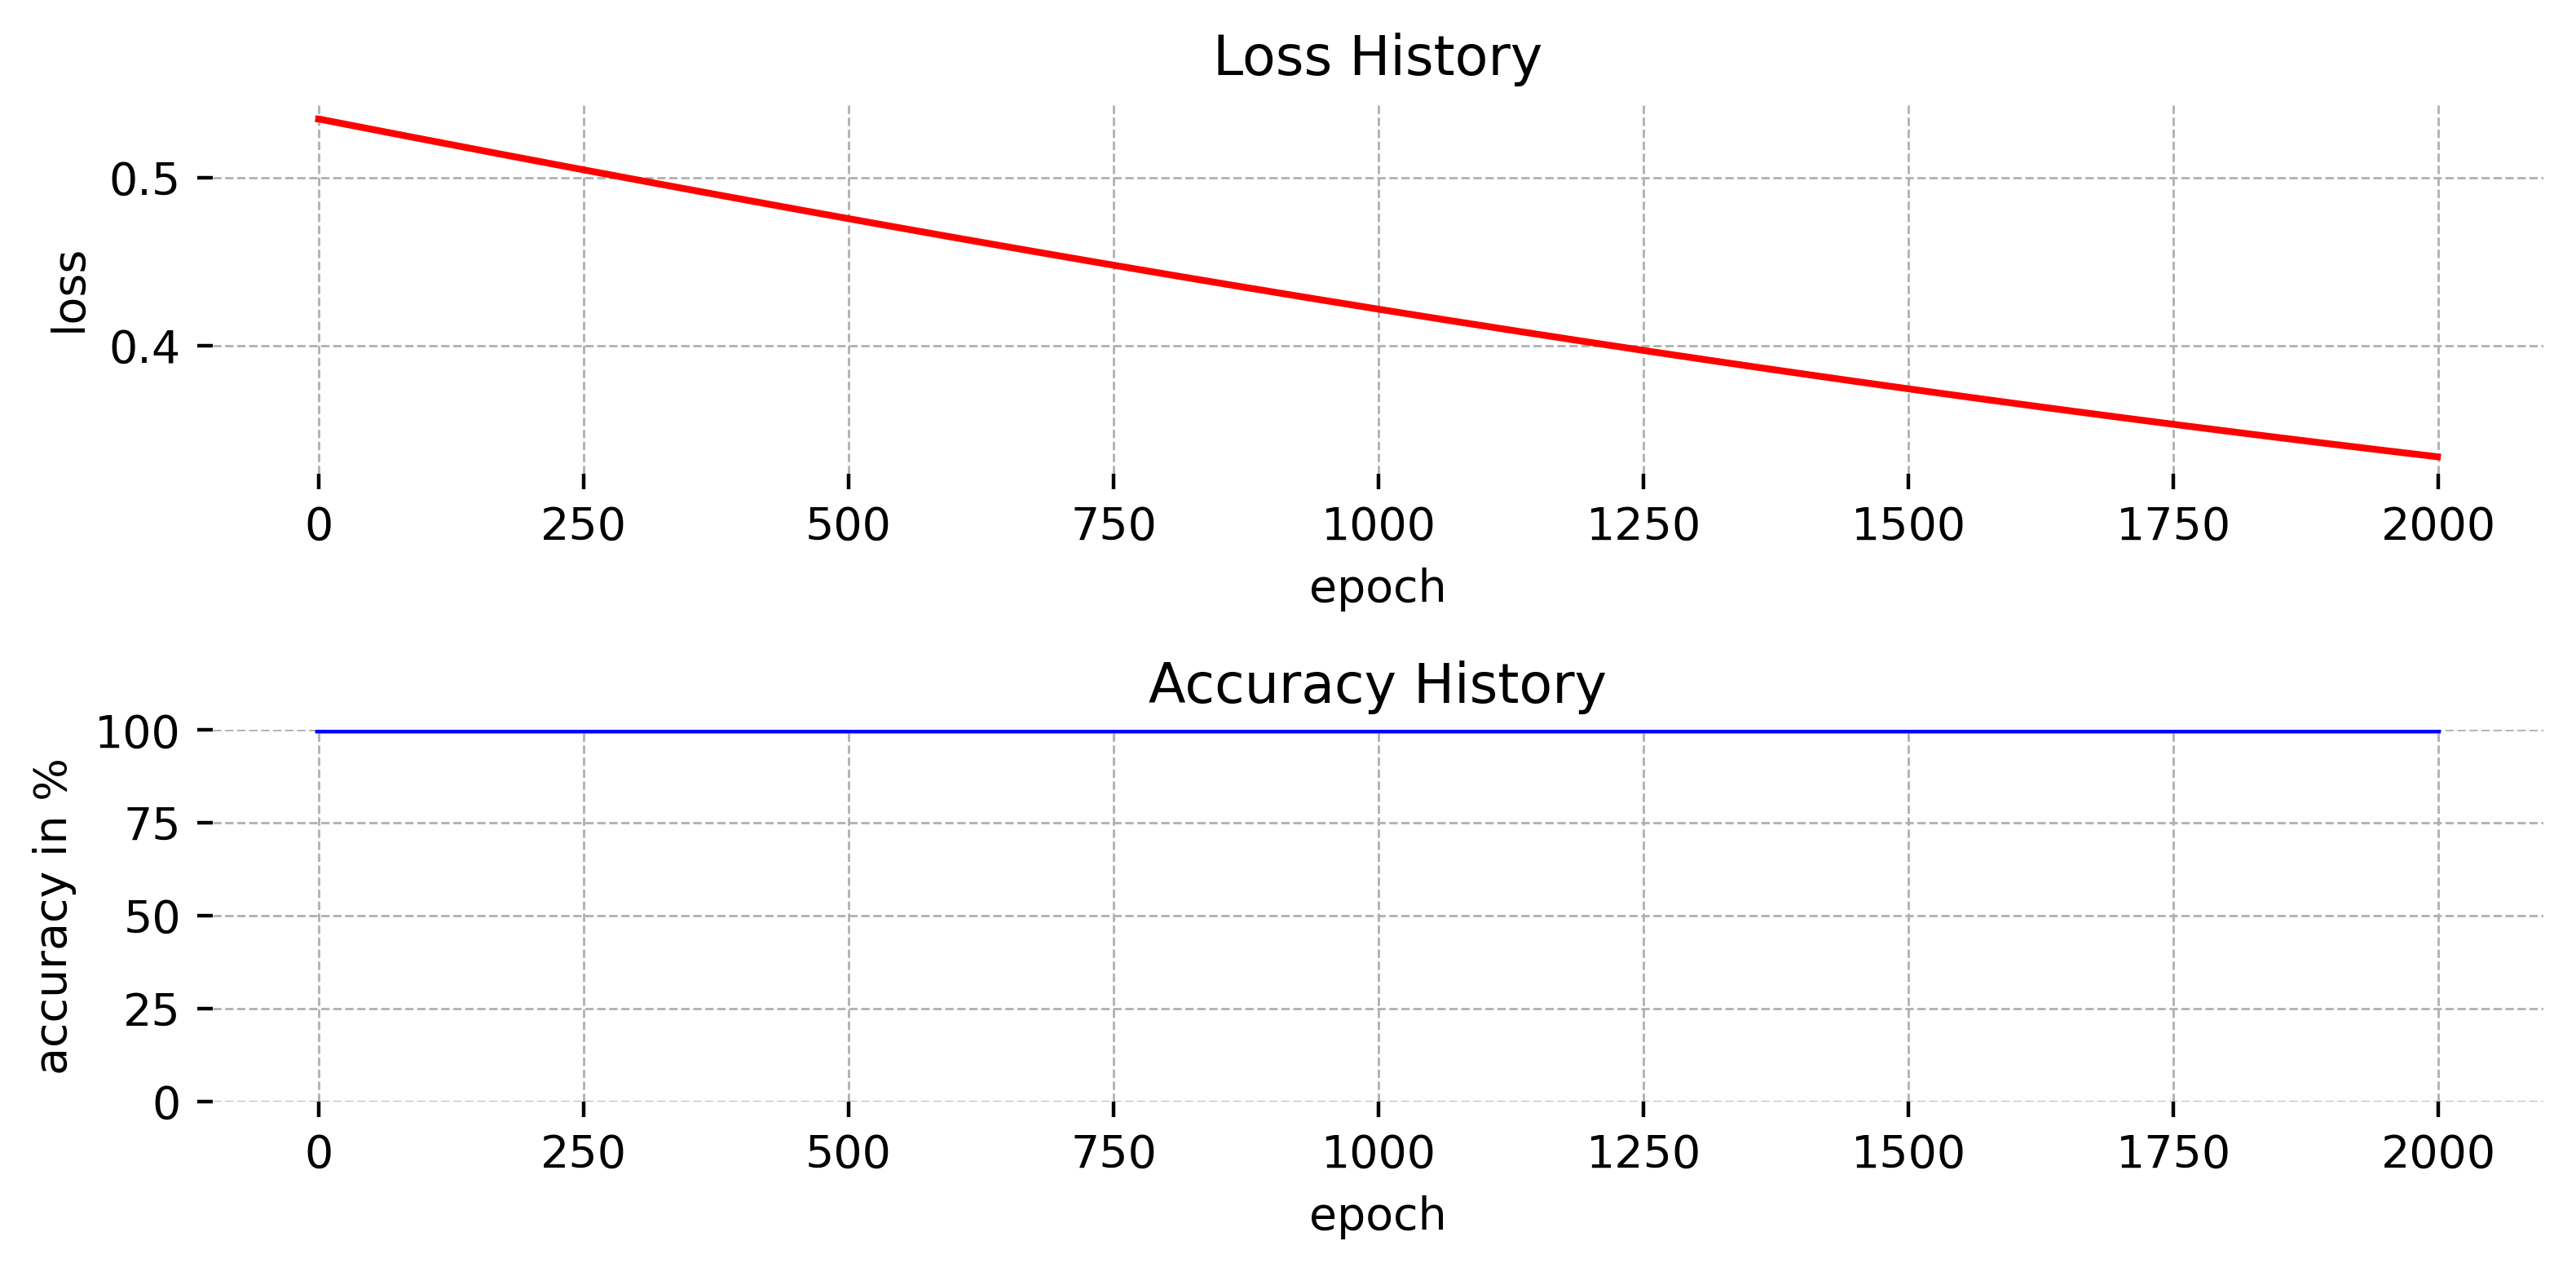

In [404]:
history = History()

with tqdm(range(epochs), desc="Epoch") as pbar:
    for epoch in pbar:
        linear_dataset.shuffle()
        
        loss, acc = 0.0, 0.0
        for x, y in linear_dataset:
            y_ = model(x)
            loss += binary_cross_entropy(y_, y) / len(linear_dataset)
            acc  += float(y == float(y_.data > 0.5)) / len(linear_dataset)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pbar.set_postfix(loss=f"{loss.data:.2e}", acc=f"{acc * 100:.2f}%")
        history.loss.append(loss.data)
        history.acc.append(acc * 100)

history.plot()

#### Decision Boundary

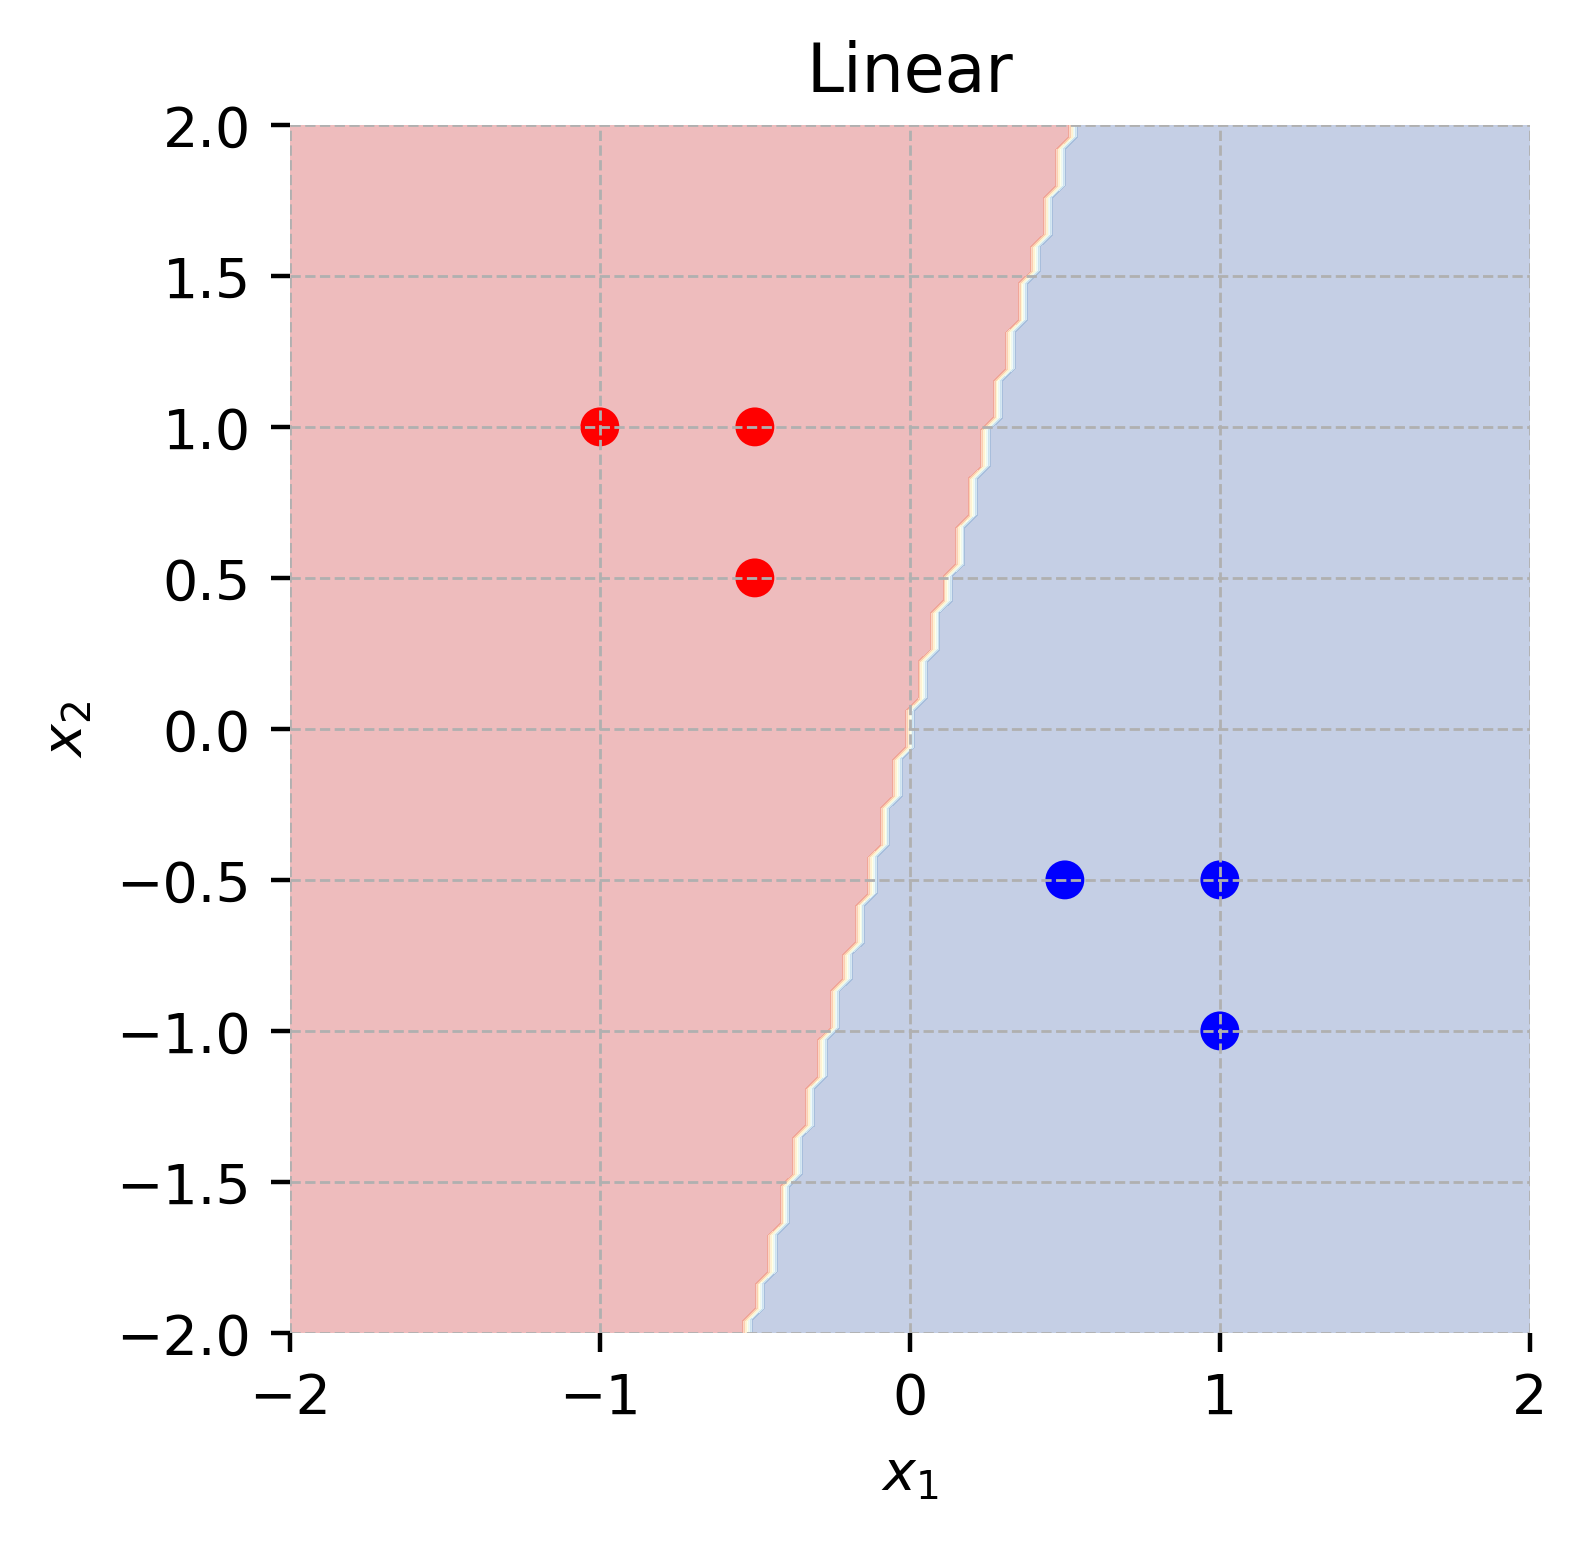

In [405]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
x = np.c_[xx.ravel(), yy.ravel()]
y = [model(x_i).data > 0.5 for x_i in x]
y = np.reshape(np.array(y), xx.shape)

fig = plt.figure(figsize=(4, 4), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.contourf(xx, yy, y, alpha=0.3, cmap=plt.cm.RdYlBu)
ax.scatter(
    x=[x_1 for x_1, _ in linear_dataset.X],
    y=[x_2 for _, x_2 in linear_dataset.X],
    c=["r" if label == 0 else "b" for label in linear_dataset.Y],
)
ax.set_title("Linear")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()

### Non Linear Problem

In this section we train a simple MLP to solve a simple non linear separable problem, a binary classifcation task.

#### Hyperparameters

In [465]:
epochs = 1_000
lr = 3 * 1e-2
momentum = 0.9
weight_decay = 1e-4
lr_decay = 1 - 1e-4

#### Model and Optimizer

In [466]:
model = MLP(2, 8, 1, activation=relu)
optim = MomentumSGD(model.parameters(), lr=lr, momentum=momentum)

#### Training Loop

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

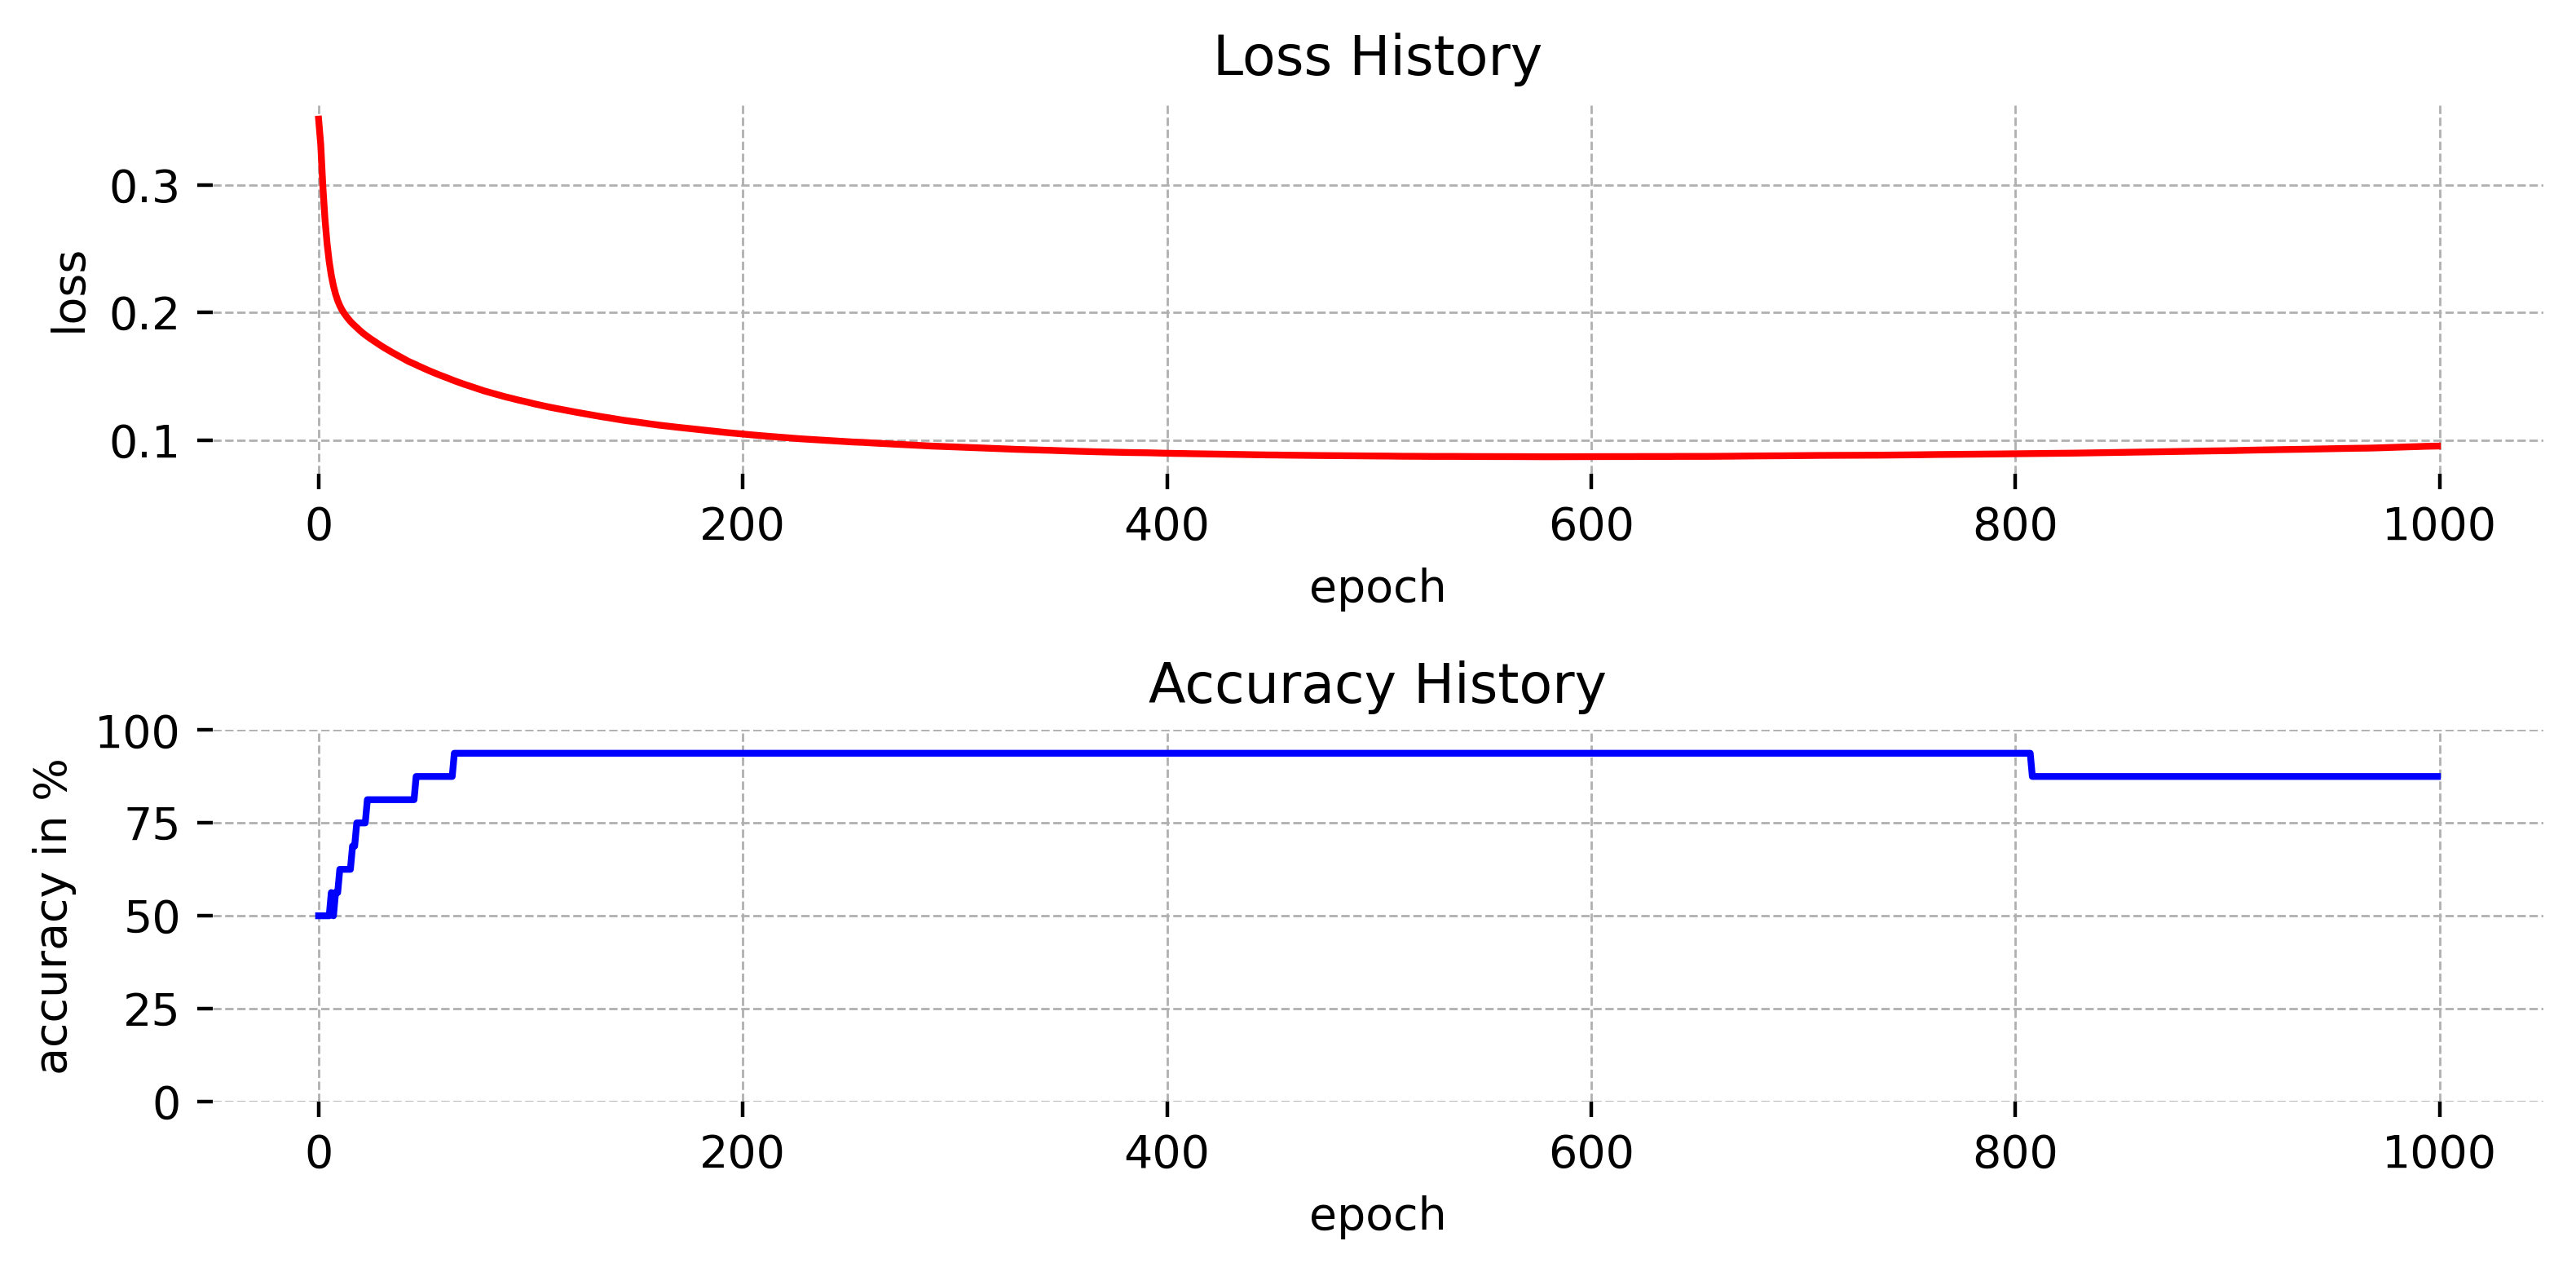

In [467]:
history = History()

with tqdm(range(epochs), desc="Epoch") as pbar:
    for epoch in pbar:
        nonlinear_dataset.shuffle()
        
        loss, acc = 0.0, 0.0
        for x, y in nonlinear_dataset:
            y_ = model(x)
            loss += squared_error(y_, y) / len(nonlinear_dataset)
            acc  += float(y == float(y_.data > 0.5)) / len(nonlinear_dataset)

        loss = loss + weight_decay * sum([param ** 2 for param in model.parameters()])

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        optim.lr = lr_decay * optim.lr

        pbar.set_postfix(loss=f"{loss.data:.2e}", acc=f"{acc * 100:.2f}%", lr=f"{optim.lr:.2e}")
        history.loss.append(loss.data)
        history.acc.append(acc * 100)

history.plot()

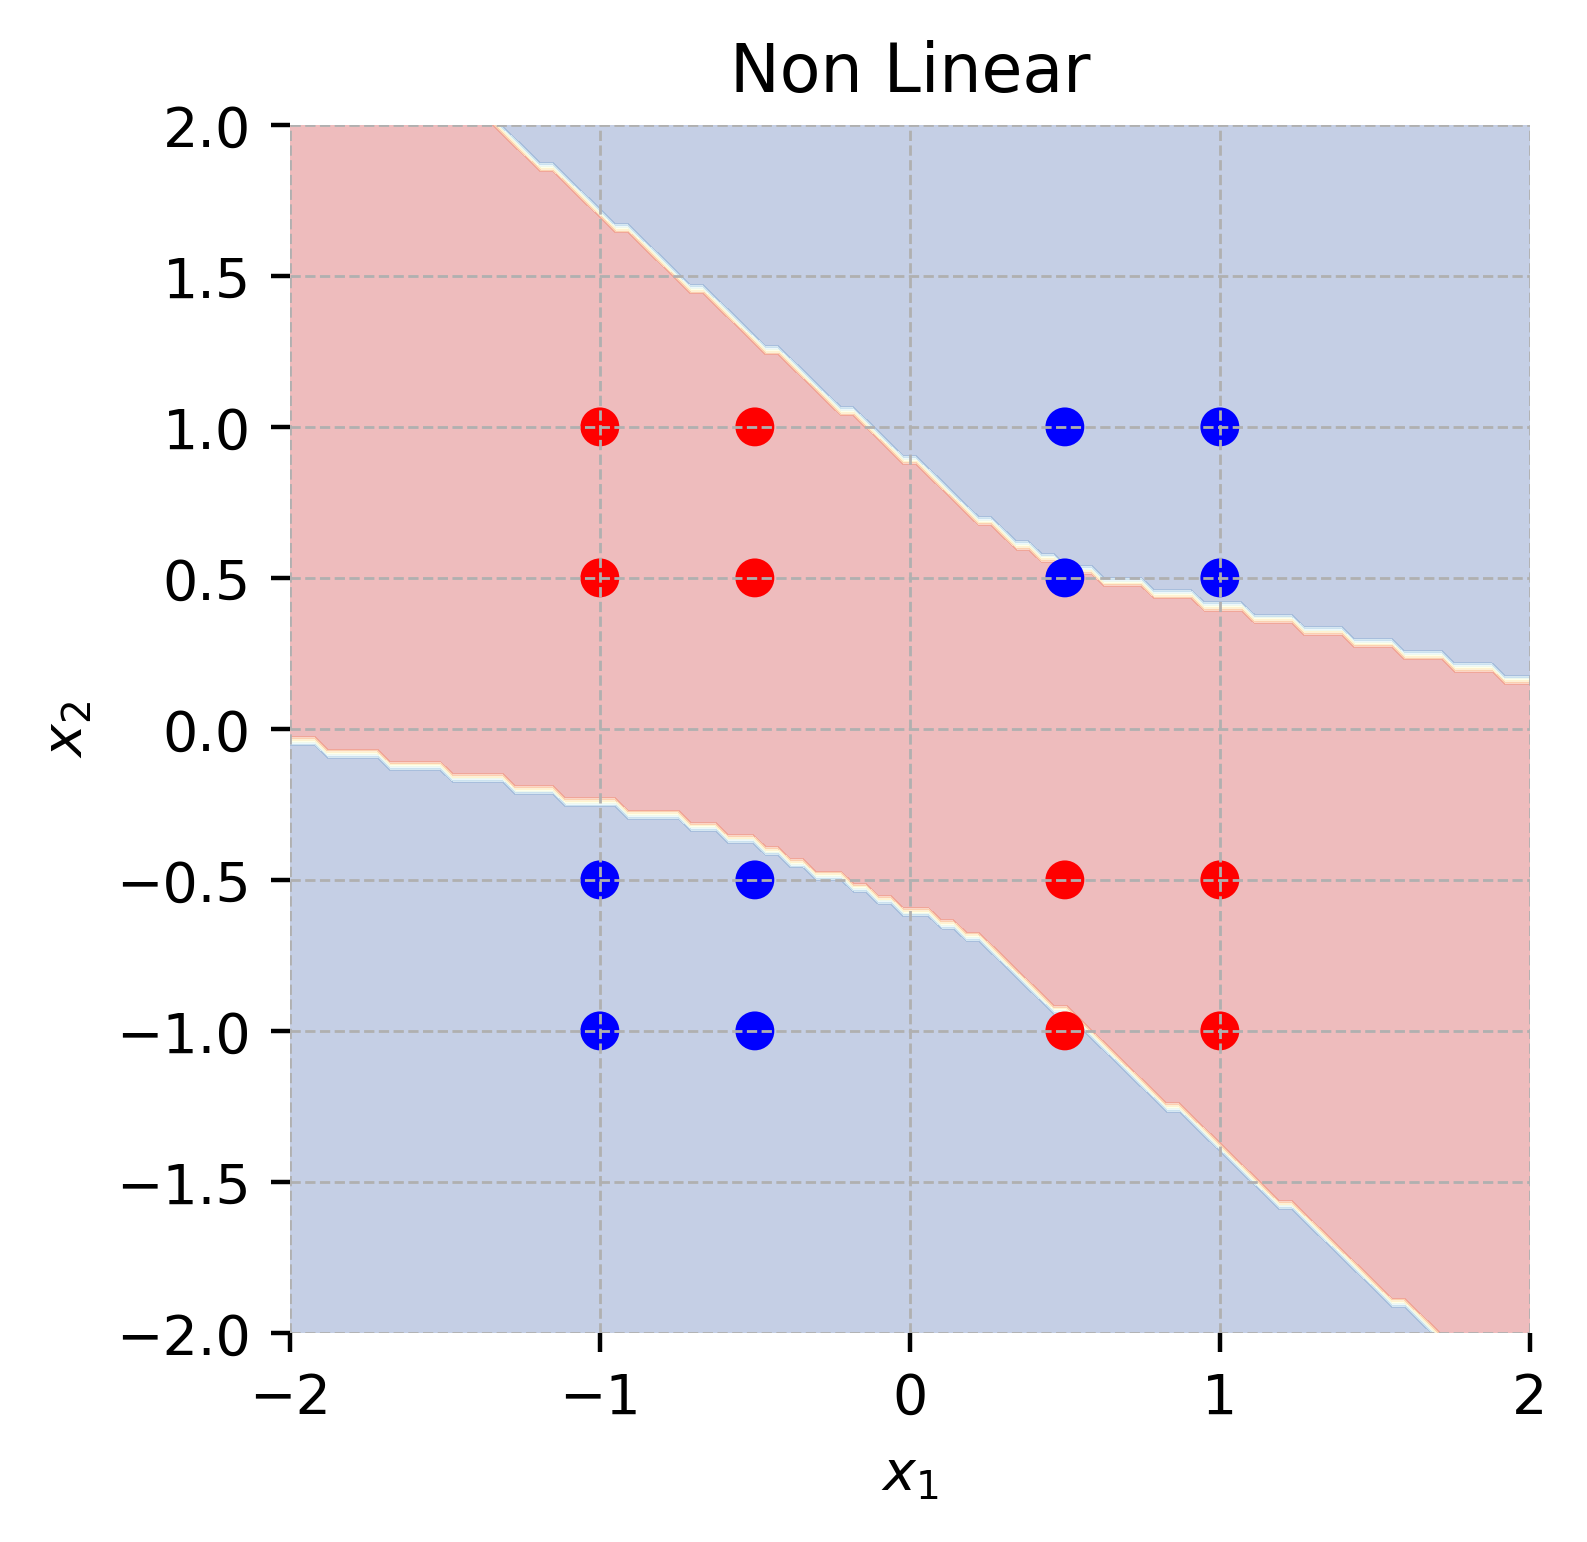

In [468]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
x = np.c_[xx.ravel(), yy.ravel()]
y = [model(x_i).data > 0.5 for x_i in x]
y = np.reshape(np.array(y), xx.shape)

fig = plt.figure(figsize=(4, 4), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.contourf(xx, yy, y, alpha=0.3, cmap=plt.cm.RdYlBu)
ax.scatter(
    x=[x_1 for x_1, _ in nonlinear_dataset.X],
    y=[x_2 for _, x_2 in nonlinear_dataset.X],
    c=["r" if label == 0 else "b" for label in nonlinear_dataset.Y],
)
ax.set_title("Non Linear")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()